In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from math import sqrt
from sklearn.linear_model import LinearRegression

In [3]:
hospital_file_list = ["datasets\h0371.xlsx", "datasets\maitland-NSW.xlsx", "datasets\Royal-women-hospital-sydney.xlsx", "datasets\h0358.xlsx","datasets\h0366.xlsx","datasets\h0374.xlsx","datasets\h0359.xlsx","datasets\h0363.xlsx","datasets\h0364.xlsx","datasets\h0038.xlsx","datasets\h0029.xlsx","datasets\h0056.xlsx","datasets\h0017.xlsx","datasets\h0021.xlsx","datasets\h0068.xlsx"]
hospital_name_list = []
hospital_data = {} #first key is hospital name, second key is description, third key is time period which leads to the data value

for hospital_file in hospital_file_list:
    file = pd.ExcelFile(hospital_file)
    hospital_name = file.parse("Tab 4").iloc[0,0]
    hospital_name_list.append(hospital_name)
    raw_data = file.parse("Tab 4")
    column_names_list = list(raw_data)
    renamed_raw = raw_data[11:].rename(columns={column_names_list[0]:'Measure',column_names_list[1]:'Patient cohort',column_names_list[2]:'Time period',column_names_list[3]:'Unit of measure', column_names_list[4]:'Data value'}) # look for in excel file
    processed_data = renamed_raw[["Measure", "Patient cohort","Time period","Unit of measure","Data value"]] # change with specific column name here
    grouped = processed_data.groupby(["Measure","Patient cohort"])
    Measure_cohort_period_value_dict_dict = {} # structure is a dict within a dict, first key being description, second key is time period that leads to the value
    # Measure cohort key for period value dict
    for measure,group in grouped:
        period_value_dict = {}
        for period in range(0,group["Time period"].shape[0]):
            period_value_dict[group["Time period"].iloc[period]] = group["Data value"].iloc[period]
        key = group["Measure"].iloc[0]+" "+ group["Patient cohort"].iloc[0]
        Measure_cohort_period_value_dict_dict[key] = period_value_dict
    hospital_data[hospital_name] = Measure_cohort_period_value_dict_dict
hospital_data

{'Hospital: Royal Melbourne Hospital [City Campus]': {'Measure Patient cohort': {'Time period': 'Data value'},
  'Median waiting time for elective surgery Cardio-thoracic surgery': {'2011–12': 9,
   '2012–13': 9,
   '2013–14': 9,
   '2014–15': 9,
   '2015–16': 10,
   '2016–17': 11,
   '2017–18': 12,
   '2018–19': 13,
   '2019–20': 10},
  'Median waiting time for elective surgery Ear, nose and throat surgery': {'2011–12': 16,
   '2012–13': 14,
   '2013–14': 13,
   '2014–15': 20,
   '2015–16': 31,
   '2016–17': 25,
   '2017–18': 27,
   '2018–19': 51,
   '2019–20': 32},
  'Median waiting time for elective surgery General surgery': {'2011–12': 21,
   '2012–13': 27,
   '2013–14': 26,
   '2014–15': 22,
   '2015–16': 26,
   '2016–17': 22,
   '2017–18': 22,
   '2018–19': 23,
   '2019–20': 22},
  'Median waiting time for elective surgery Neurosurgery': {'2011–12': 29,
   '2012–13': 36,
   '2013–14': 51,
   '2014–15': 29,
   '2015–16': 52,
   '2016–17': 46,
   '2017–18': 45,
   '2018–19': 62,
  

In [4]:
hospital_name_list

['Hospital: Royal Melbourne Hospital [City Campus]',
 'Hospital: Maitland Hospital',
 'Hospital: Royal Hospital for Women',
 'Hospital: The Alfred',
 "Hospital: Royal Women's Hospital [Parkville]",
 "Hospital: St Vincent's Hospital [Melbourne]",
 'Hospital: Austin Hospital [Heidelberg]',
 'Hospital: Western Hospital [Footscray]',
 "Hospital: Royal Children's Hospital [Parkville]",
 'Hospital: St George Hospital NSW',
 'Hospital: Campbelltown Hospital',
 'Hospital: Nepean Hospital',
 "Hospital: St Vincent's Hospital [Darlinghurst]",
 'Hospital: Royal Prince Alfred Hospital',
 'Hospital: Royal North Shore Hospital']

In [5]:
measure_cohort_dict = {}
for hospital in hospital_data.keys():
    for measure_cohort in hospital_data[hospital].keys():
        measure_cohort_dict[measure_cohort] = []
        
for hospital in hospital_data.keys():
    for measure_cohort in hospital_data[hospital].keys():
        measure_list = []
        for time_period in hospital_data[hospital][measure_cohort].keys():
            measure_list.append(hospital_data[hospital][measure_cohort][time_period])
        hospital_measure_list = [hospital]
        hospital_measure_list.append(measure_list)
        measure_cohort_dict[measure_cohort].append(hospital_measure_list)
measure_cohort_dict

{'Measure Patient cohort': [['Hospital: Royal Melbourne Hospital [City Campus]',
   ['Data value']],
  ['Hospital: Maitland Hospital', ['Data value']],
  ['Hospital: Royal Hospital for Women', ['Data value']],
  ["Hospital: Royal Women's Hospital [Parkville]", ['Data value']],
  ["Hospital: St Vincent's Hospital [Melbourne]", ['Data value']],
  ['Hospital: Austin Hospital [Heidelberg]', ['Data value']],
  ['Hospital: Western Hospital [Footscray]', ['Data value']],
  ["Hospital: Royal Children's Hospital [Parkville]", ['Data value']],
  ['Hospital: St George Hospital NSW', ['Data value']],
  ['Hospital: Campbelltown Hospital', ['Data value']],
  ['Hospital: Nepean Hospital', ['Data value']],
  ["Hospital: St Vincent's Hospital [Darlinghurst]", ['Data value']],
  ['Hospital: Royal North Shore Hospital', ['Data value']]],
 'Median waiting time for elective surgery Cardio-thoracic surgery': [['Hospital: Royal Melbourne Hospital [City Campus]',
   [9, 9, 9, 9, 10, 11, 12, 13, 10]],
  ['Hosp

In [6]:
cleaned_measure_cohort_dict = {}
for measure_cohort in measure_cohort_dict.keys():
    cleaned_measure_cohort_dict[measure_cohort] = []

for measure_cohort in measure_cohort_dict.keys():
    for hospital_index in range(0,len(measure_cohort_dict[measure_cohort])-1):
        hospital_name_data_list = []
        hospital_name_data_list.append(measure_cohort_dict[measure_cohort][hospital_index][0])
        if len(measure_cohort_dict[measure_cohort][hospital_index][1]) == 9:
            data_list = []
            indicator = 0
            for data in measure_cohort_dict[measure_cohort][hospital_index][1]:
                if data == "NP" or data == "-":
                    indicator = 1
                elif data == "<5":
                    data_list.append(2)
                else:
                    data_list.append(data)
            if indicator == 0:
                hospital_name_data_list.append(data_list)
                cleaned_measure_cohort_dict[measure_cohort].append(hospital_name_data_list)            
del cleaned_measure_cohort_dict['Measure Patient cohort']
cleaned_measure_cohort_dict

{'Median waiting time for elective surgery Cardio-thoracic surgery': [['Hospital: Royal Melbourne Hospital [City Campus]',
   [9, 9, 9, 9, 10, 11, 12, 13, 10]],
  ['Hospital: The Alfred', [13, 18, 13, 11, 15, 14, 15, 14, 21]],
  ["Hospital: St Vincent's Hospital [Melbourne]",
   [24, 25, 28, 27, 28, 28, 29, 28, 24]],
  ['Hospital: Austin Hospital [Heidelberg]',
   [26, 25, 28, 27, 26, 20, 22, 26, 26]],
  ['Hospital: Western Hospital [Footscray]',
   [15, 15, 14, 12, 18, 15, 16, 12, 10]],
  ["Hospital: Royal Children's Hospital [Parkville]",
   [45, 11, 53, 74, 80, 44, 50, 45, 70]],
  ['Hospital: St George Hospital NSW', [22, 27, 19, 22, 24, 27, 23, 19, 20]],
  ['Hospital: Nepean Hospital', [24, 22, 26, 23, 20, 28, 23, 28, 16]],
  ["Hospital: St Vincent's Hospital [Darlinghurst]",
   [9, 11, 8, 12, 12, 14, 9, 8, 9]],
  ['Hospital: Royal Prince Alfred Hospital',
   [12, 14, 15, 25, 23, 16, 23, 19, 17]]],
 'Median waiting time for elective surgery Ear, nose and throat surgery': [['Hospita

In [7]:
median_waiting_time_dict = {}
number_of_surgery_dict = {}
for key in cleaned_measure_cohort_dict.keys():
    if key[0] == "M":
        median_waiting_time_dict[key] = cleaned_measure_cohort_dict[key]
    elif key[0] == "N":
        number_of_surgery_dict[key] = cleaned_measure_cohort_dict[key]
print(median_waiting_time_dict.keys())

RMH_median_waiting_time_general_surgery_list = [] # An example
for hospital_name_and_data in median_waiting_time_dict["Median waiting time for elective surgery General surgery"]:
    hospital_name = hospital_name_and_data[0]
    if hospital_name == "Hospital: Royal Melbourne Hospital [City Campus]":
        data = hospital_name_and_data[1]
        RMH_median_waiting_time_general_surgery_list = data
        break
RMH_median_waiting_time_general_surgery_list 
X = np.array(RMH_median_waiting_time_general_surgery_list[0:7])
X = X.reshape(-1,1)
y = RMH_median_waiting_time_general_surgery_list[1:8]
reg = LinearRegression().fit(X,y)
data_18_19 = np.array(RMH_median_waiting_time_general_surgery_list)
data_18_19 = data_18_19[-2]
data_18_19 = data_18_19.reshape(1,-1)
y_pred = reg.predict(data_18_19)

dict_keys(['Median waiting time for elective surgery Cardio-thoracic surgery', 'Median waiting time for elective surgery Ear, nose and throat surgery', 'Median waiting time for elective surgery General surgery', 'Median waiting time for elective surgery Neurosurgery', 'Median waiting time for elective surgery Ophthalmology', 'Median waiting time for elective surgery Orthopaedic surgery', 'Median waiting time for elective surgery Other surgery', 'Median waiting time for elective surgery Plastic surgery', 'Median waiting time for elective surgery Urology', 'Median waiting time for elective surgery Vascular surgery', 'Median waiting time for elective surgery Gynaecology', 'Median waiting time for elective surgery Paediatric surgery'])


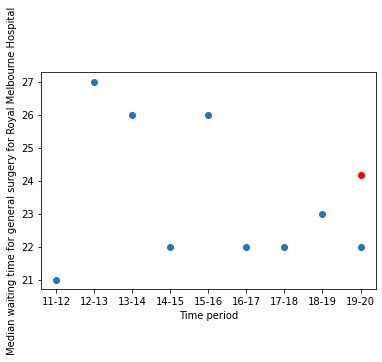

19-20 forecast:  [24.17175573]
19-20 actual:  22


In [8]:
time_period = ["11-12","12-13","13-14","14-15","15-16","16-17","17-18","18-19","19-20"]
plt.scatter(time_period,RMH_median_waiting_time_general_surgery_list)
plt.plot(["19-20"],y_pred,"or")
plt.ylabel("Median waiting time for general surgery for Royal Melbourne Hospital")
plt.xlabel("Time period")
plt.show()
print("19-20 forecast: ", y_pred)
print("19-20 actual: ", RMH_median_waiting_time_general_surgery_list[-1])

In [9]:
RMH_median_waiting_time_Cardio_thoracic_surgery_list = [] # An example
for hospital_name_and_data in median_waiting_time_dict["Median waiting time for elective surgery Cardio-thoracic surgery"]:
    hospital_name = hospital_name_and_data[0]
    if hospital_name == "Hospital: Royal Melbourne Hospital [City Campus]":
        data = hospital_name_and_data[1]
        RMH_median_waiting_time_Cardio_thoracic_surgery_list = data
        break
RMH_median_waiting_time_Cardio_thoracic_surgery_list 
X = np.array(RMH_median_waiting_time_Cardio_thoracic_surgery_list[0:7])
X = X.reshape(-1,1)
y = RMH_median_waiting_time_Cardio_thoracic_surgery_list[1:8]
reg = LinearRegression().fit(X,y)
data_18_19 = np.array(RMH_median_waiting_time_Cardio_thoracic_surgery_list)
data_18_19 = data_18_19[-2]
data_18_19 = data_18_19.reshape(1,-1)
y_pred = reg.predict(data_18_19)

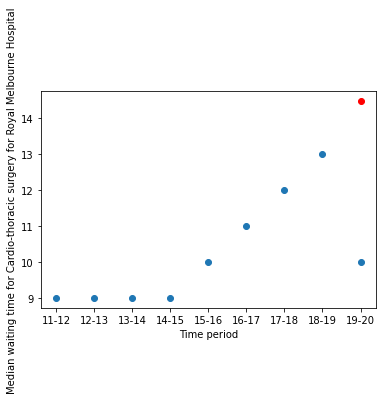

19-20 forecast:  [14.48387097]
19-20 actual:  10


In [10]:
time_period = ["11-12","12-13","13-14","14-15","15-16","16-17","17-18","18-19","19-20"]
plt.scatter(time_period,RMH_median_waiting_time_Cardio_thoracic_surgery_list )
plt.plot(["19-20"],y_pred,"or")
plt.ylabel("Median waiting time for Cardio-thoracic surgery for Royal Melbourne Hospital")
plt.xlabel("Time period")
plt.show()
print("19-20 forecast: ", y_pred)
print("19-20 actual: ", RMH_median_waiting_time_Cardio_thoracic_surgery_list [-1])

In [11]:
print(number_of_surgery_dict.keys()) # keys are exactly similar with the same order
RMH_number_of_general_surgery_list = [] # An example
#Hospital: Royal Melbourne Hospital [City Campus]
for hospital_name_and_data in number_of_surgery_dict["Number of elective surgeries General surgery"]:
    hospital_name = hospital_name_and_data[0]
    if hospital_name == "Hospital: Royal Melbourne Hospital [City Campus]":
        data = hospital_name_and_data[1]
        RMH_number_of_general_surgery_list = data
        break
RMH_number_of_general_surgery_list
X = np.array(RMH_number_of_general_surgery_list[0:7])
X = X.reshape(-1,1)
y = RMH_number_of_general_surgery_list[1:8]
reg = LinearRegression().fit(X,y)
data_18_19 = np.array(RMH_number_of_general_surgery_list)
data_18_19 = data_18_19[-2]
data_18_19 = data_18_19.reshape(1,-1)
y_pred = reg.predict(data_18_19)

dict_keys(['Number of elective surgeries Cardio-thoracic surgery', 'Number of elective surgeries Ear, nose and throat surgery', 'Number of elective surgeries General surgery', 'Number of elective surgeries Neurosurgery', 'Number of elective surgeries Ophthalmology', 'Number of elective surgeries Orthopaedic surgery', 'Number of elective surgeries Other surgery', 'Number of elective surgeries Plastic surgery', 'Number of elective surgeries Urology', 'Number of elective surgeries Vascular surgery', 'Number of elective surgeries Gynaecology', 'Number of elective surgeries Paediatric surgery'])


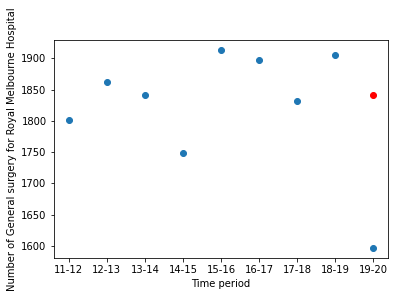

19-20 forecast:  [1840.85562385]
19-20 actual:  1597


In [12]:
time_period = ["11-12","12-13","13-14","14-15","15-16","16-17","17-18","18-19","19-20"]
plt.scatter(time_period,RMH_number_of_general_surgery_list)
plt.plot(["19-20"],y_pred,"or")
plt.ylabel("Number of General surgery for Royal Melbourne Hospital")
plt.xlabel("Time period")
plt.show()
print("19-20 forecast: ", y_pred)
print("19-20 actual: ", RMH_number_of_general_surgery_list[-1])

In [13]:
RMH_number_of_Cardio_thoracic_surgery_list = [] # An example
#Hospital: Royal Melbourne Hospital [City Campus]
for hospital_name_and_data in number_of_surgery_dict["Number of elective surgeries Cardio-thoracic surgery"]:
    hospital_name = hospital_name_and_data[0]
    if hospital_name == "Hospital: Royal Melbourne Hospital [City Campus]":
        data = hospital_name_and_data[1]
        RMH_number_of_Cardio_thoracic_surgery_list = data
        break
RMH_number_of_Cardio_thoracic_surgery_list
X = np.array(RMH_number_of_Cardio_thoracic_surgery_list[0:7])
X = X.reshape(-1,1)
y = RMH_number_of_Cardio_thoracic_surgery_list[1:8]
reg = LinearRegression().fit(X,y)
data_18_19 = np.array(RMH_number_of_Cardio_thoracic_surgery_list)
data_18_19 = data_18_19[-2]
data_18_19 = data_18_19.reshape(1,-1)
y_pred = reg.predict(data_18_19)

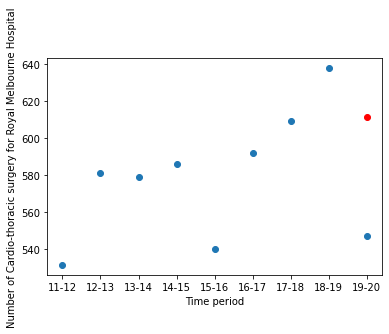

19-20 forecast:  [611.33433122]
19-20 actual:  547


In [14]:
time_period = ["11-12","12-13","13-14","14-15","15-16","16-17","17-18","18-19","19-20"]
plt.scatter(time_period,RMH_number_of_Cardio_thoracic_surgery_list)
plt.plot(["19-20"],y_pred,"or")
plt.ylabel("Number of Cardio-thoracic surgery for Royal Melbourne Hospital")
plt.xlabel("Time period")
plt.show()
print("19-20 forecast: ", y_pred)
print("19-20 actual: ", RMH_number_of_Cardio_thoracic_surgery_list[-1])

In [15]:
median_waiting_time_dict
median_waiting_time_dict_with_RMH = {}

number_of_surgery_dict
number_of_surgery_dict_with_RMH = {}

for key in median_waiting_time_dict.keys():
    for hospital_name_data in median_waiting_time_dict[key]:
        hospital_name = hospital_name_data[0]
        if hospital_name == "Hospital: Royal Melbourne Hospital [City Campus]":
            median_waiting_time_dict_with_RMH[key] = median_waiting_time_dict[key]
            break
            
for key in number_of_surgery_dict.keys():
    for hospital_name_data in number_of_surgery_dict[key]:
        hospital_name = hospital_name_data[0]
        if hospital_name == "Hospital: Royal Melbourne Hospital [City Campus]":
            number_of_surgery_dict_with_RMH[key] = number_of_surgery_dict[key]
            break
            
median_waiting_time_dict_with_RMH
#number_of_surgery_dict_with_RMH

{'Median waiting time for elective surgery Cardio-thoracic surgery': [['Hospital: Royal Melbourne Hospital [City Campus]',
   [9, 9, 9, 9, 10, 11, 12, 13, 10]],
  ['Hospital: The Alfred', [13, 18, 13, 11, 15, 14, 15, 14, 21]],
  ["Hospital: St Vincent's Hospital [Melbourne]",
   [24, 25, 28, 27, 28, 28, 29, 28, 24]],
  ['Hospital: Austin Hospital [Heidelberg]',
   [26, 25, 28, 27, 26, 20, 22, 26, 26]],
  ['Hospital: Western Hospital [Footscray]',
   [15, 15, 14, 12, 18, 15, 16, 12, 10]],
  ["Hospital: Royal Children's Hospital [Parkville]",
   [45, 11, 53, 74, 80, 44, 50, 45, 70]],
  ['Hospital: St George Hospital NSW', [22, 27, 19, 22, 24, 27, 23, 19, 20]],
  ['Hospital: Nepean Hospital', [24, 22, 26, 23, 20, 28, 23, 28, 16]],
  ["Hospital: St Vincent's Hospital [Darlinghurst]",
   [9, 11, 8, 12, 12, 14, 9, 8, 9]],
  ['Hospital: Royal Prince Alfred Hospital',
   [12, 14, 15, 25, 23, 16, 23, 19, 17]]],
 'Median waiting time for elective surgery Ear, nose and throat surgery': [['Hospita

In [16]:
median_waiting_time_forecast_for_RMH = {}

for key in median_waiting_time_dict_with_RMH.keys():
    X_list = []
    Y_list = []
    for hospital_data in median_waiting_time_dict_with_RMH[key]:
        first_X_sample = hospital_data[1][0:4] # 11-12, 12-13, 13-14, 14-15 time period as X
        first_Y_sample = hospital_data[1][4] # Y is 15-16
        second_X_sample = hospital_data[1][4:8] # 15-16, 16-17, 17-18, 18-19 time period as X
        second_Y_sample = hospital_data[1][8] # Y is 19-20
        X_list.append(first_X_sample)
        X_list.append(second_X_sample)
        Y_list.append(first_Y_sample)
        Y_list.append(second_Y_sample)
        reg = LinearRegression().fit(X_list,Y_list)
        prediction = reg.predict([median_waiting_time_dict_with_RMH[key][0][1][5:9]])
        median_waiting_time_forecast_for_RMH[key] = prediction
        
median_waiting_time_forecast_for_RMH

{'Median waiting time for elective surgery Cardio-thoracic surgery': array([9.7749644]),
 'Median waiting time for elective surgery Ear, nose and throat surgery': array([43.33223399]),
 'Median waiting time for elective surgery General surgery': array([20.30867815]),
 'Median waiting time for elective surgery Neurosurgery': array([42.1517122]),
 'Median waiting time for elective surgery Ophthalmology': array([113.10365385]),
 'Median waiting time for elective surgery Orthopaedic surgery': array([44.06819972]),
 'Median waiting time for elective surgery Plastic surgery': array([23.45751374]),
 'Median waiting time for elective surgery Urology': array([17.88795228]),
 'Median waiting time for elective surgery Vascular surgery': array([27.11553783])}

In [17]:
number_of_surgery_forecast_for_RMH = {}

for key in number_of_surgery_dict_with_RMH.keys():
    X_list = []
    Y_list = []
    for hospital_data in number_of_surgery_dict_with_RMH[key]:
        first_X_sample = hospital_data[1][0:4] # 11-12, 12-13, 13-14, 14-15 time period as X
        first_Y_sample = hospital_data[1][4] # Y is 15-16
        second_X_sample = hospital_data[1][4:8] # 15-16, 16-17, 17-18, 18-19 time period as X
        second_Y_sample = hospital_data[1][8] # Y is 19-20
        X_list.append(first_X_sample)
        X_list.append(second_X_sample)
        Y_list.append(first_Y_sample)
        Y_list.append(second_Y_sample)
        reg = LinearRegression().fit(X_list,Y_list)
        prediction = reg.predict([number_of_surgery_dict_with_RMH[key][0][1][5:9]])
        number_of_surgery_forecast_for_RMH[key] = prediction
        
number_of_surgery_forecast_for_RMH

{'Number of elective surgeries Cardio-thoracic surgery': array([489.19028929]),
 'Number of elective surgeries Ear, nose and throat surgery': array([152.19050894]),
 'Number of elective surgeries General surgery': array([1524.73202218]),
 'Number of elective surgeries Neurosurgery': array([715.29067807]),
 'Number of elective surgeries Ophthalmology': array([386.87300462]),
 'Number of elective surgeries Orthopaedic surgery': array([1029.76394022]),
 'Number of elective surgeries Plastic surgery': array([788.1529015]),
 'Number of elective surgeries Urology': array([2010.75409311]),
 'Number of elective surgeries Vascular surgery': array([195.35121189])}